In [1]:
from scipy import sparse
import numpy as np
import itertools
import copy

from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
import pandas as pd

import sys
sys.path.append("..")
import utils


def fast_dice(X, Y=None):
    if isinstance(X, np.ndarray):
        X = sparse.csr_matrix(X).astype(bool).astype(int)
    if Y is None:
        Y = X
    else:
        if isinstance(Y, np.ndarray):
            Y = sparse.csr_matrix(Y).astype(bool).astype(int)

    intersect = X.dot(Y.T)
    #cardinality = X.sum(1).A
    cardinality_X = X.getnnz(1)[:,None] #slightly faster on large matrices - 13s vs 16s for 12k x 12k
    cardinality_Y = Y.getnnz(1) #slightly faster on large matrices - 13s vs 16s for 12k x 12k
    return (1-(2*intersect) / (cardinality_X+cardinality_Y.T)).A

#all labels:
interaction_matrix = sparse.load_npz('../data/interaction_matrix_pchembl.npz')
y = interaction_matrix.toarray()
#correlation matrix:
L = utils.makeCorrelations(interaction_matrix).toarray()

# get ligands with more than one label.
# Because you can't make predictions from the correlation matrix
# when you've removed the only known positive.
multiple_labels = np.sum(y,axis=1)>1

#this function removes the influence of one ligand from the correlation graph, i.e. LOO.
def subtractLigand(L, row, tot_instances):
    P = copy.copy(L) #don't want to change the values in L or it will change over time.
                    #take a copy each time we want to subtract a ligand, to keep L constant.
    for j,k in itertools.permutations(np.where(row==1)[0], 2):
        P[j][k] -= (1)/(tot_instances[k])
    return 1-P


/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '
  0%|          | 211/85681 [00:00<00:40, 2102.20it/s]

y_in shape is: (337951, 243)


100%|██████████| 85681/85681 [00:28<00:00, 2959.52it/s]


In [2]:
fps = sparse.load_npz('../time_split/morgan.npz')
fps_multiples = fps[multiple_labels]
y_multiples = y[multiple_labels]

In [3]:
tot_instances = np.sum(y, axis=0)
trials=1000
rank_list = list()
hit_list = list()
miss_list = list()
similarities = list()

In [97]:
# ##Do LOO ranking:
# for idx in tqdm(multiple_labels.nonzero()[0]): #for every multilabel ligand
#     labels = y[idx] #fetch this ligand's labels
#     L1 = subtractLigand(L, y[idx], tot_instances) #remove knowledge of this ligand from the correlation matrix:
#     ones = np.where(labels==1)[0] #positive label indices
#     zeros = np.where(labels==0)[0] #unknown label indices

#     scores = np.zeros(labels.shape[0])
#     for o in ones: #for each positive, set it's label to zero. Then calculate probability of a hit
#         labels = copy.copy(y[idx])
#         labels[o]=0
#         probs_pos = 1-np.prod(L1[o][labels==1])
#         scores[o]=probs_pos
#     for z in zeros: #for each zero, calculate the probability of a hit
#         labels = copy.copy(y[idx])
#         probs_pos = 1-np.prod(L1[z][labels==1])
#         scores[z]=probs_pos
#     for o in ones:
#         test_ligand = fps[idx]
#         other_ligands = fps[y[:,o]==1]
#         nnsimilarities =fast_dice(test_ligand, other_ligands)[0]
#         nn = nnsimilarities[np.argsort(nnsimilarities)[1]]
#         similarities.append(nn)

#     #these are the ranks of the predicted probabilities for this ligand
#     ranks_unadjusted = np.argsort(-scores).argsort()[labels.astype(bool)]+1

#     #now increase the worse ranked positives by the number of positives in front of it
#     #for example if two ligands ranked 1, 2, we count it as 1,1
#     #this is because we don't want to penalise perfect ranking of two ligands in a row.
#     ranks_adj = ranks_unadjusted-(ranks_unadjusted).argsort().argsort()

#     #for calculating calibration:
#     hit_list += list(scores[labels.astype(bool)])
#     miss_list += list(scores[~labels.astype(bool)])

#     rank_list += list(ranks_adj)

# Do LOO without removing nearest neighbors:

In [111]:
import seaborn as sns
from seaborn import kdeplot

num_trials = 1000
sample = np.random.choice(multiple_labels.nonzero()[0], num_trials)

tot_instances = np.sum(y, axis=0)
rank_list = list()
hit_list = list()
miss_list = list()
similarities = list()

##Do LOO ranking:
for idx in tqdm.tqdm_notebook(sample): #for every multilabel ligand
    labels = y[idx] #fetch this ligand's labels
    L1 = subtractLigand(L, y[idx], tot_instances) #remove knowledge of this ligand from the correlation matrix:
    ones = np.where(labels==1)[0] #positive label indices
    zeros = np.where(labels==0)[0] #unknown label indices

    scores = np.zeros(labels.shape[0])
    
    #For each positive label, set it's label to zero ('leaving it out'). 
    #Then calculate the probability it would be a hit
    for o in ones:
        labels = copy.copy(y[idx])
        labels[o]=0
        probs_pos = 1-np.prod(L1[o][labels==1])
        scores[o]=probs_pos
    
    #for each zero label, calculate the probability of a hit
    for z in zeros: 
        labels = copy.copy(y[idx])
        probs_pos = 1-np.prod(L1[z][labels==1])
        scores[z]=probs_pos
        
    #now, separate to the rankings, also calculate 
    #the distances to ALL other positive labels. 
    for o in ones:
        test_ligand = fps[idx]
        other_ligands = fps_multiples[y_multiples[:,o]==1]
        nnsimilarities =fast_dice(test_ligand, other_ligands)[0]
        similarities.append(nnsimilarities)
        
        #this is just saving the 1-NN:
        #nn = nnsimilarities[np.argsort(nnsimilarities)[1]]


    #these are the ranks of the predicted probabilities for this ligand
    ranks_unadjusted = np.argsort(-scores).argsort()[labels.astype(bool)]+1

    #now increase the worse ranked positives by the number of positives in front of it
    #for example if two ligands ranked 1, 2, we count it as 1,1
    #this is because we don't want to penalise perfect ranking of two ligands in a row.
    ranks_adj = ranks_unadjusted-(ranks_unadjusted).argsort().argsort()

    #for calculating calibration:
    hit_list += list(scores[labels.astype(bool)])
    miss_list += list(scores[~labels.astype(bool)])

    rank_list += list(ranks_adj)
    
ranks = np.array(rank_list)

In [211]:
np.array([i[np.argsort(i)][1:N] for i in similarities]).shape

(2878, 29)

In [114]:
s = list()
N = 30
for i in similarities:
    #take most similar N
    
    most_similar = i[np.argsort(i)][1:N]
    s.append(np.mean(most_similar))

In [115]:
###
##Plot an ECDF of different similarities:
###


# import matplotlib.pyplot as plt
# plt.figure(figsize=(14,12))
# _, bins = pd.qcut(s, 8, retbins=True)
# for interval in range(len(bins)-1):
#     mask = (np.array(s)>bins[interval]) & (np.array(s)<bins[interval+1])
#     ranks_m = ranks[mask]
#     s_m = np.array(s)[mask]
#     ecdf = ECDF(ranks_m)
#     plt.plot(ecdf.x, ecdf.y, label=str(np.around(bins[interval],2))+'-'+str(np.around(bins[interval+1], 2)))

# plt.legend(fontsize=24)
# plt.xlim(0,20)

In [116]:
d = pd.DataFrame(columns=['s', 'r'], data={'s':s, 'r':ranks})
d = d[d['r']<10]


Text(0.5, 1.0, 'Nearest-neighbor Dice distance per rank')

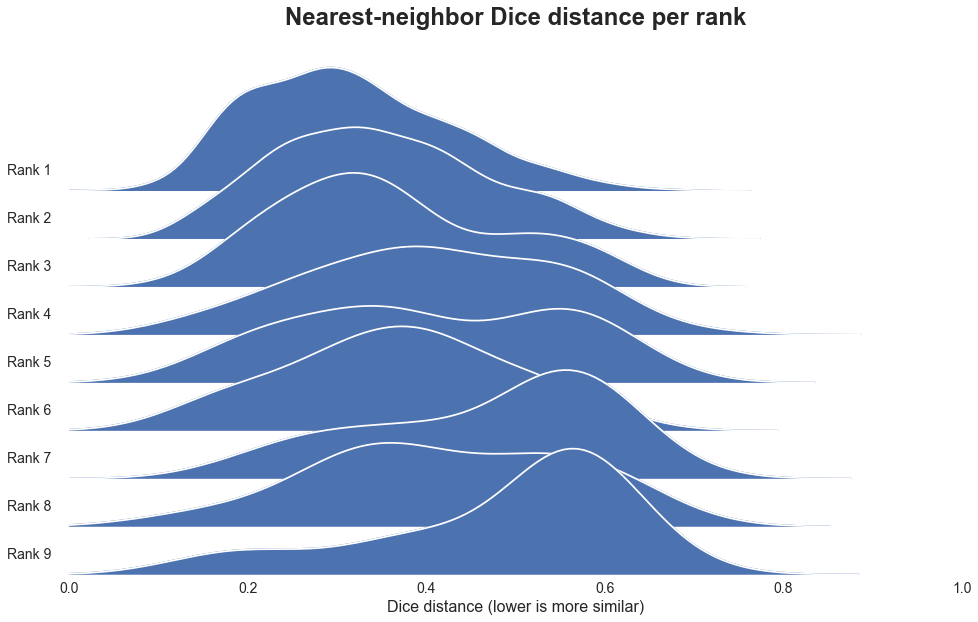

In [117]:
import matplotlib.gridspec as grid_spec
gs = grid_spec.GridSpec(9,1)
gs.update(hspace= -0.7)

fig = plt.figure(figsize=(16,9))

fig.set_figheight(10)
i = 0

ax_objs = []
for j,k in d.groupby('r'):
    
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))
    kdeplot(k.s, shade=True, ax = ax_objs[-1],alpha=1, legend=False)
    kdeplot(k.s, shade=False, ax = ax_objs[-1],alpha=1, color='white', legend=False)
    ax_objs[-1].grid()
    # setting uniform x and y lims
    ax_objs[-1].set_xlim(0,1)
    ax_objs[-1].set_ylim(0,4.5)
    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)
    ax_objs[-1].set_yticklabels([])
    spines = ["top","right","left","bottom"]
    
    ax_objs[-1].set_yticklabels([])
    ax_objs[-1].set_yticks([])
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)
    if i == 8:
        ax_objs[-1].set_xlabel("Dice distance (lower is more similar)", fontsize=16,)
        for tick in ax_objs[-1].xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    else:
        ax_objs[-1].set_xticklabels([])
    spines = ["top","right","left","bottom"]
    adj_country = "Rank "+str(j)+'\n'
    ax_objs[-1].text(-0.02,0,adj_country,fontsize=14,ha="right")


    i+=1
    
ax_objs[0].set_title('Nearest-neighbor Dice distance per rank', fontsize=24,fontweight="bold")

# Do LOO while removing nearest neighbors.

In [22]:
#this function removes the influence of one ligand from the correlation graph, i.e. LOO.
def subtractMultipleLigands(L, rows, tot_instances):
    P = copy.copy(L) #don't want to change the values in L or it will change over time.
                    #take a copy each time we want to subtract a ligand, to keep L constant.
    for row in rows:
        if row.sum()>1:
            for j,k in itertools.permutations(np.where(row==1)[0], 2):
                P[j][k] -= (1)/(tot_instances[k])
    return 1-P



In [194]:
import tqdm 

num_trials=5000

sample = np.random.choice(multiple_labels.nonzero()[0], num_trials)

tot_instances = np.sum(y, axis=0)
nn_removed_rank_list = list()
nn_removed_similarities = list()

nn_cutoff = 0.4

##Do LOO ranking:
for idx in tqdm.tqdm_notebook(sample): #for every multilabel ligand
    labels = y[idx] #fetch this ligand's labels
    
    ones = np.where(labels==1)[0] #positive label indices
    zeros = np.where(labels==0)[0] #unknown label indices

    scores = np.zeros(labels.shape[0])
    
    #For each positive label, set it's label to zero ('leaving it out'). 
    #Then calculate the probability it would be a hit
    ##This time, however, also remove labels of all nearest neighbors!
    for o in ones: 
        labels = copy.copy(y[idx])
        labels[o]=0 #set the left-out ligand label to 0. 
        
        #remove the labels from the nearest neighbours (i.e. with distance<cutoff):
        test_ligand = fps[idx] #this is the left-out ligand
        other_ligand_indices = np.where(y[:,o]==1)[0] #all other positives with the same label.
        other_ligands = fps[other_ligand_indices] #this is their fingerprints
        nnsimilarities =fast_dice(test_ligand, other_ligands)[0] #list of Dice distances
        
        nearest_neighbor_mask = nnsimilarities<nn_cutoff #we will remove all of these nearest neighbors
        nearest_neighbor_indices = other_ligand_indices[nearest_neighbor_mask]
        #remove knowledge of this ligand from the correlation matrix:
        L_multiple_ligands_removed = subtractMultipleLigands(L, y[nearest_neighbor_indices], tot_instances) 

        #Now, like the first time, calculate the probability this left-out ligand is a hit:
        probs_pos = 1-np.prod(L_multiple_ligands_removed[o][labels==1])
        scores[o]=probs_pos
        
        #since we have already calculated nearest-neighbor distances, 
        #might as well use that list instead of re-calculating
        
        #these are the similarities to training set ligands:
        remaining_nnsimilarities = nnsimilarities[~nearest_neighbor_mask] 
        
        nn_removed_similarities.append(remaining_nnsimilarities)
        
    for z in zeros: #for each zero, calculate the probability of a hit
        labels = copy.copy(y[idx])
        probs_pos = 1-np.prod(L1[z][labels==1])
        scores[z]=probs_pos


    #these are the ranks of the predicted probabilities for this ligand
    ranks_unadjusted = np.argsort(-scores).argsort()[labels.astype(bool)]+1

    #now increase the worse ranked positives by the number of positives in front of it
    #for example if two ligands ranked 1, 2, we count it as 1,1
    #this is because we don't want to penalise perfect ranking of two ligands in a row.
    ranks_adj = ranks_unadjusted-(ranks_unadjusted).argsort().argsort()

    ##for calculating calibration:
    #hit_list += list(scores[labels.astype(bool)])
    #miss_list += list(scores[~labels.astype(bool)])

    nn_removed_rank_list += list(ranks_adj)
    
    
    

In [209]:
np.array([i[:30] for i in nn_removed_similarities])

array([[0.75956284, 0.60893855, 0.76470588, ..., 0.70886076, 0.76536313,
        0.67857143],
       [0.67708333, 0.78205128, 0.71751412, ..., 0.72619048, 0.70930233,
        0.75438596],
       [0.75949367, 0.67708333, 0.73493976, ..., 0.67032967, 0.73033708,
        0.63736264],
       ...,
       [0.75193798, 0.72932331, 0.81395349, ..., 0.60305344, 0.56923077,
        0.68794326],
       [0.69398907, 0.65217391, 0.73262032, ..., 0.70044053, 0.65482234,
        0.66169154],
       [0.69398907, 0.65217391, 0.66523605, ..., 0.68421053, 0.68558952,
        0.64485981]])

In [195]:

nn_removed_ranks = np.array(nn_removed_rank_list)

nn_removed_s = list()
N = 30
for i in nn_removed_similarities:
    #take most similar N
    
    most_similar = i[np.argsort(i)][1:N]
    nn_removed_s.append(np.mean(most_similar))
    
    
d = pd.DataFrame(columns=['s', 'r'], data={'s':nn_removed_s, 'r':nn_removed_ranks})
d = d[d['r']<10]


Text(0.5, 1.0, 'Nearest-neighbor Dice distance per rank')

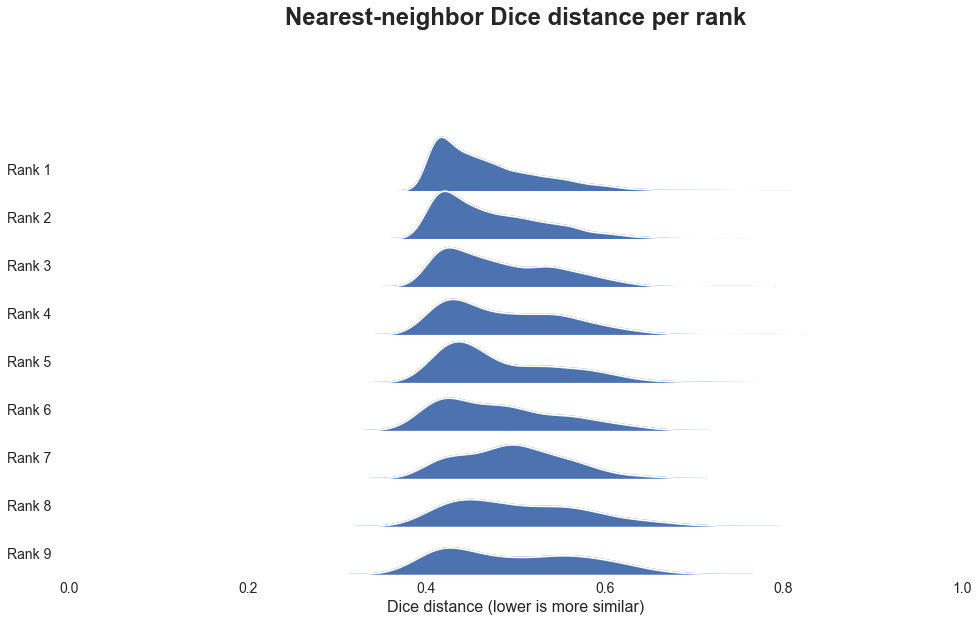

In [196]:
import matplotlib.gridspec as grid_spec
gs = grid_spec.GridSpec(9,1)
gs.update(hspace= -0.7)

fig = plt.figure(figsize=(16,9))

fig.set_figheight(10)
i = 0

ax_objs = []
for j,k in d.groupby('r'):
    
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))
    kdeplot(k.s, shade=True, ax = ax_objs[-1],alpha=1, legend=False)
    kdeplot(k.s, shade=False, ax = ax_objs[-1],alpha=1, color='white', legend=False)
    ax_objs[-1].grid()
    # setting uniform x and y lims
    ax_objs[-1].set_xlim(0,1)
    ax_objs[-1].set_ylim(0,30.5)
    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)
    ax_objs[-1].set_yticklabels([])
    spines = ["top","right","left","bottom"]
    
    ax_objs[-1].set_yticklabels([])
    ax_objs[-1].set_yticks([])
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)
    if i == 8:
        ax_objs[-1].set_xlabel("Dice distance (lower is more similar)", fontsize=16,)
        for tick in ax_objs[-1].xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    else:
        ax_objs[-1].set_xticklabels([])
    spines = ["top","right","left","bottom"]
    adj_country = "Rank "+str(j)+'\n'
    ax_objs[-1].text(-0.02,0,adj_country,fontsize=14,ha="right")


    i+=1
    
ax_objs[0].set_title('Nearest-neighbor Dice distance per rank', fontsize=24,fontweight="bold")

In [151]:
import numpy as np

from scipy import sparse
from scipy.stats import gaussian_kde

import pandas as pd
import six

import sys
sys.path.append("..")
import utils

import pymc3 as pm

import tqdm
import itertools

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('seaborn')

from statsmodels.distributions.empirical_distribution import ECDF
def calc_hpd(ranks, statistic=np.mean):
    with pm.Model() as model:
        #prior on statistic of interest:
        a = pm.Normal('a', mu=statistic(ranks), sigma=10.0)
        #'nuisance' parameter:
        b = pm.HalfNormal('b', sigma=10.0)
        #likelihood:
        if statistic==np.mean:
            y = pm.Normal('y', mu=a, sigma=b, observed=ranks)
        elif statistic==np.median:
            y = pm.Laplace('y', mu=a, b=b,observed=ranks)
        trace = pm.sample(draws=500, tune=500, chains=2, target_accept=0.9)

    return trace

def calc_kde(ranks, xs=np.linspace(1,244,244)):
    #kde:
    density = gaussian_kde(ranks)
    density.covariance_factor= lambda : 0.25
    density._compute_covariance()
    return density(xs)

In [197]:
# nn_removed_tr = calc_hpd(np.log10(nn_removed_ranks/242), np.mean)
# tr = calc_hpd(np.log10(ranks/242), np.mean)

nn_removed_tr = calc_hpd(logit((np.clip(nn_removed_ranks, 1,241)/242)), np.mean)
tr = calc_hpd(logit((np.clip(ranks, 1,241)/242)), np.mean)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 625.63draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1729.45draws/s]


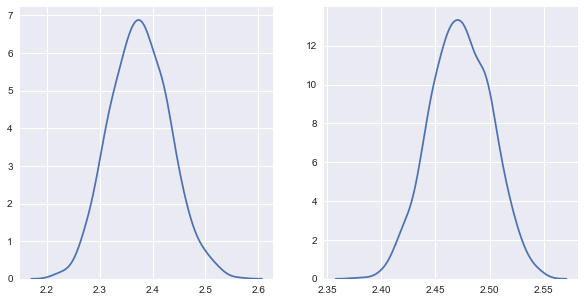

In [198]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(10)
fig.set_figheight(5)
kdeplot(expit(tr['a'])*242, ax=ax[0])
kdeplot(expit(nn_removed_tr['a'])*242, ax=ax[1])

In [199]:
# nn_removed_tr = calc_hpd(np.log10(nn_removed_ranks/242), np.median)
# tr = calc_hpd(np.log10(ranks/242), np.median)

nn_removed_tr = calc_hpd(logit((np.clip(nn_removed_ranks, 1,241)/242)), np.median)
tr = calc_hpd(logit((np.clip(ranks, 1,241)/242)), np.median)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:08<00:00, 227.37draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:06<00:00, 317.39draws/s]
The acceptance probability does not match the target. It is 0.8349904292370703, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [200]:
from scipy.special import expit, logit

In [201]:
pm.stats.hpd(expit(tr['a'])*242)

array([0.99937737, 1.11559568])

In [202]:
pm.stats.hpd(expit(nn_removed_tr['a'])*242)

array([0.99992262, 1.02590371])

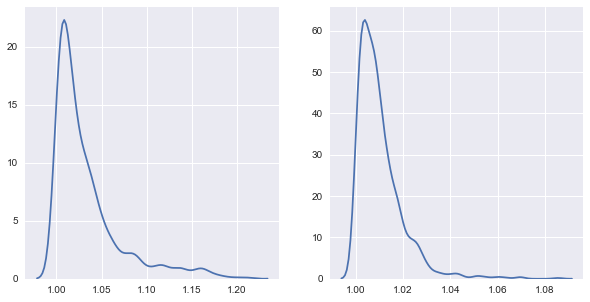

In [203]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(10)
fig.set_figheight(5)
kdeplot(expit(tr['a'])*242, ax=ax[0])
kdeplot(expit(nn_removed_tr['a'])*242, ax=ax[1])

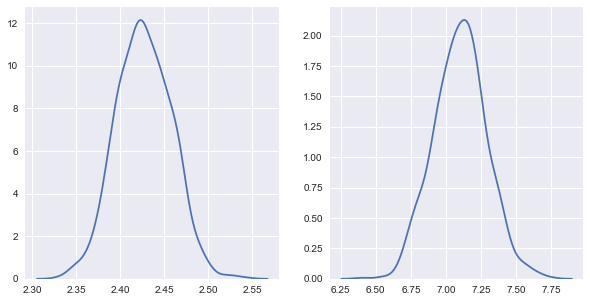

In [49]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(10)
fig.set_figheight(5)
kdeplot(10**tr['a']*242, ax=ax[0])
kdeplot(mean_trace['a'], ax=ax[1])

In [33]:
rank_arr = np.array(ranks)
mean_trace = calc_hpd(np.array(rank_arr), np.mean)
median_trace = calc_hpd(np.array(rank_arr), np.median)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 934.06draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:08<00:00, 248.56draws/s]
The acceptance probability does not match the target. It is 0.8369099115532174, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [34]:
def plot_fig_label(ax, lab):
    ax.text(-0.15, 1.12, lab, transform=ax.transAxes,
        fontsize=24, va='top', ha='left')

7.100649415971014 [6.72386478 7.41649804]
1.1516730177240215 [0.99908713 1.42996626]


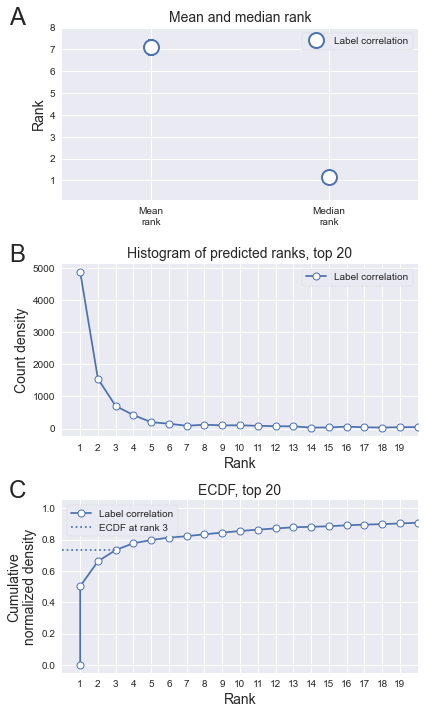

In [35]:
fig, ax = plt.subplots(nrows=3,ncols=1)
fig.set_figheight(10)
fig.set_figwidth(6)

label='Label correlation'
for count,trace,name in zip([0,1], [mean_trace, median_trace], ['mean rank', 'median rank']):
    m = np.mean(trace['a'])
    hpd = pm.hpd(trace['a'])
    print(m, hpd)
    xs = np.linspace(m-3,m+3,100)
    density = calc_kde(trace['a'], xs=xs)

    ax[0].errorbar(count, m, yerr = np.array([m-hpd[0], hpd[1]-m])[:,None],mfc='white',mew=2,
                           fmt='o', c='C0',linewidth=4, markersize=15, capsize=3, label=label)
    label=None
    
    
ax[0].set_xticks([0,1])
ax[0].set_xticklabels(['Mean\nrank', 'Median\nrank'])
ax[0].set_xlim(-0.5,1.5)
#ax[0].errorbar(-10,3, label='Label correlation')
ax[0].legend(frameon=True, fancybox=True, framealpha=1)
ax[0].set_ylabel('Rank', fontsize=14)
ax[0].set_ylim(0.1,8)
ax[0].set_title('Mean and median rank', fontsize=14)
plot_fig_label(ax[0], 'A')

n, x = np.histogram(np.array(rank_arr), bins = np.linspace(1,243,243))
#bin_centers = 0.5*(x[1:]+x[:-1])
#ax[1].plot(bin_centers,n,'-o', mfc='white', label='Label correlation')
#ax[1].plot(x[:-1],n,'-o', mfc='white', label='Label correlation')
ax[1].plot(x[:-1],n,'-o', mfc='white', mew=1, label='Label correlation')
#ax[1].scatter(bin_centers,n,label='Label correlation')
ax[1].set_xlim(0,20)
ax[1].set_xticks(np.arange(1,20))
ax[1].set_xlabel('Rank', fontsize=14)
ax[1].set_ylabel('Count density',fontsize=14)
ax[1].set_title('Histogram of predicted ranks, top 20',fontsize=14)
ax[1].legend(frameon=True, fancybox=True, framealpha=1)
plot_fig_label(ax[1], 'B')

ecdf = np.cumsum(n)/n.sum()
ax[2].plot([1]+list(x[:-1]),[0]+list(ecdf), '-o', mfc='white', mew=1, label='Label correlation')
ax[2].set_xlim(0.0,20)
ax[2].set_xticks(np.arange(1,20))
ax[2].plot([0,3],[ecdf[2],ecdf[2]],c='C0', linestyle=':', label='ECDF at rank 3')
ax[2].legend(frameon=True, fancybox=True, framealpha=1)
ax[2].set_ylabel('Cumulative\nnormalized density', fontsize=14)
ax[2].set_xlabel('Rank',fontsize=14)
ax[2].set_title('ECDF, top 20',fontsize=14)
plot_fig_label(ax[2], 'C')


plt.tight_layout()

In [9]:
hit_arr = np.load('hit_arr.npy')
miss_arr = np.load('miss_arr.npy')

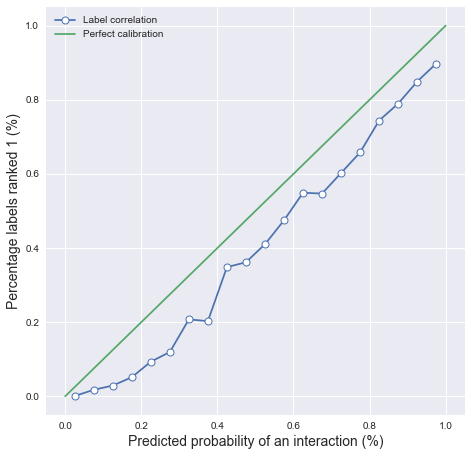

In [10]:

    
fig, ax = plt.subplots()
fig.set_figheight(7.5)
fig.set_figwidth(7.5)

x = np.linspace(0,1,21)
h = np.histogram(hit_arr, bins=x)
m = np.histogram(miss_arr, bins=x)

ax.plot(x[:-1]+0.025, h[0]/(m[0]+h[0]), '-o', mfc='white', mew=1, label='Label correlation')

ax.set_ylabel('Percentage labels ranked 1 (%)', fontsize=14)
ax.set_xlabel('Predicted probability of an interaction (%)', fontsize=14)
ax.plot([0,1],[0,1], label='Perfect calibration')
ax.legend()

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


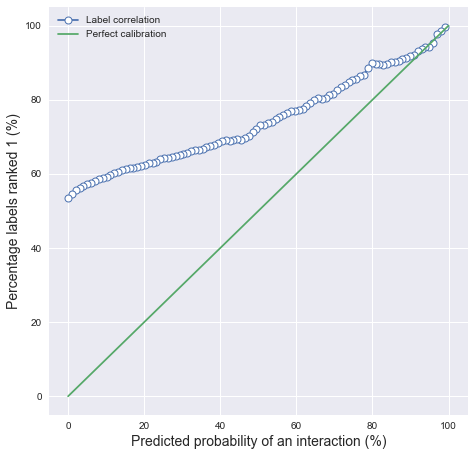

In [3]:
##Plot calibration:
rank_arr = np.load('rank_arr.npy')
score_arr = np.load('score_arr.npy')

x =np.linspace(1,0,100)
metric = list()
for cutoff in x:
    ranks = rank_arr[score_arr>=cutoff]
    n = len(ranks)
    val =(ranks<=1).sum()/n
    metric.append(val)

fig, ax = plt.subplots()
fig.set_figheight(7.5)
fig.set_figwidth(7.5)

ax.plot(x*100, np.array(metric)*100, '-o', mfc='white', mew=1, label='Label correlation')
ax.set_ylabel('Percentage labels ranked 1 (%)', fontsize=14)
ax.set_xlabel('Predicted probability of an interaction (%)', fontsize=14)
ax.plot([0,100],[0,100], label='Perfect calibration')
ax.legend()

In [613]:
train, test = utils.load_time_split(year=2010)

FileNotFoundError: [Errno 2] No such file or directory: 'label_correlation.npy'

In [614]:
train.data.shape

(233955,)

In [615]:
test.data.shape

(2494,)

In [11]:
interaction_matrix = sparse.load_npz('../data/interaction_matrix_pchembl.npz')
interaction_dates = sparse.load_npz('../data/interaction_dates_pchembl.npz')

#turn interaction dates into a masker
dates_mask = (interaction_dates.data<=2010).astype(int)

In [12]:
interaction_matrix.shape

(337951, 243)

In [579]:
dates_mask.sum()

233955

In [616]:
interaction_matrix.data.shape[0] - dates_mask.sum()

249688

In [619]:
interaction_matrix.data.shape[0]

483643

In [618]:
dates_mask.sum()/ interaction_matrix.data.shape[0]

0.48373490363760047

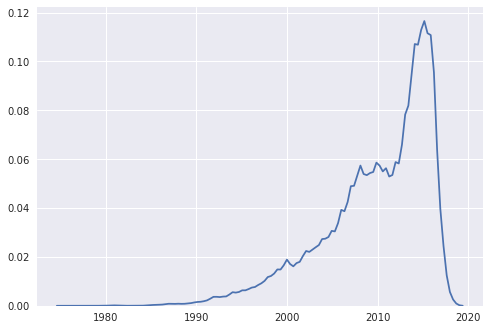

In [577]:
kdeplot(interaction_dates.data[interaction_dates.data>2])

In [561]:
dates_mask

array([1, 0, 1, ..., 1, 1, 1])

In [389]:
names = pd.read_csv('../data/subset_targets', header=None)
names.columns=['Protein Name']
names

,Protein Name
0,Leucine-rich repeat serine/threonine-protein k...
1,Bromodomain-containing protein 4
2,Nuclear receptor ROR-gamma
3,Nicotinamide phosphoribosyltransferase
4,Corticotropin releasing factor receptor 1
...,...
238,Glucose-dependent insulinotropic receptor
239,Prostaglandin E synthase
240,Mitogen-activated protein kinase kinase kinase 14
241,Smoothened homolog


In [390]:
all_interactions = sparse.load_npz('../data/interaction_matrix_pchembl.npz').toarray()
mask = np.sum(all_interactions, axis=1)
mask = mask>1

interaction_matrix = all_interactions[mask]

tot_instances = all_interactions.sum(0)

#interaction_matrix = interaction_matrix[:,np.sum(interaction_matrix, axis=0)>0]

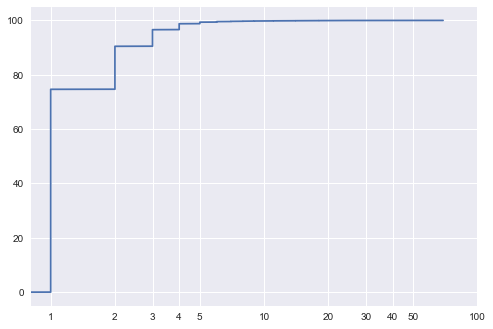

In [391]:
ec = ECDF(np.sum(all_interactions, axis=1))
plt.plot(ec.x, ec.y*100)
plt.xscale('log')
plt.xticks([1,2,3,4,5,10,20,30,40,50,100], [1,2,3,4,5,10,20,30,40,50,100]);


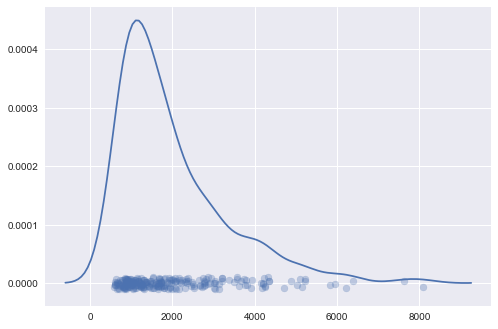

In [392]:
from seaborn import kdeplot
kdeplot(all_interactions.sum(0))
plt.scatter(all_interactions.sum(0), 
            np.zeros(all_interactions.shape[1])+np.random.uniform(-1e-5, 1e-5, all_interactions.shape[1]),
            alpha=0.3
           )

In [393]:
fraction_multilabel = interaction_matrix.sum(0)/tot_instances

In [394]:
names['%']=np.around(fraction_multilabel*100, 2)

In [395]:
names =names.sort_values(by='%', ascending=False)

In [396]:
ecdf = np.cumsum(names['%']) / np.sum(names['%'])

In [397]:
all_totals = np.sum(all_interactions, 0)

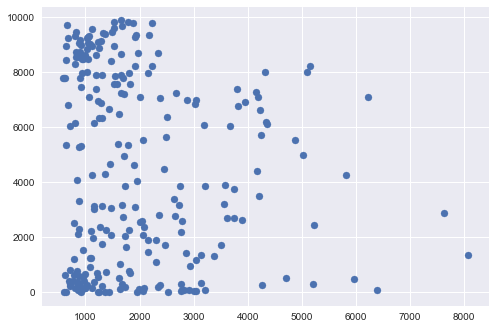

In [398]:
plt.scatter(all_totals, names['%']*100)

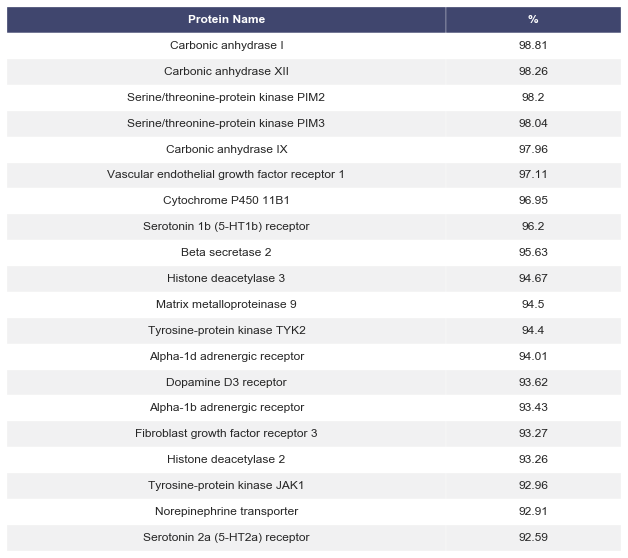

In [430]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import six


def render_mpl_table(data, sizes, col_width=10.0, row_height=0.625, font_size=12,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
    ax.axis('off')
    
    mpl_table = ax.table(cellText=data.values, 
                         bbox=bbox, 
                         colLabels=data.columns, 
                         cellLoc='center', 
                         colWidths=sizes,
                         **kwargs)
    

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
            cell.set_text_props(wrap=True, fontstretch='ultra-condensed')
    return ax

fig, ax = plt.subplots()

ax = render_mpl_table(names.iloc[:20], np.array([2,0.8]), header_columns=0, col_width=2.0, ax=ax)

fig.set_figwidth(11)
fig.set_figheight(10)

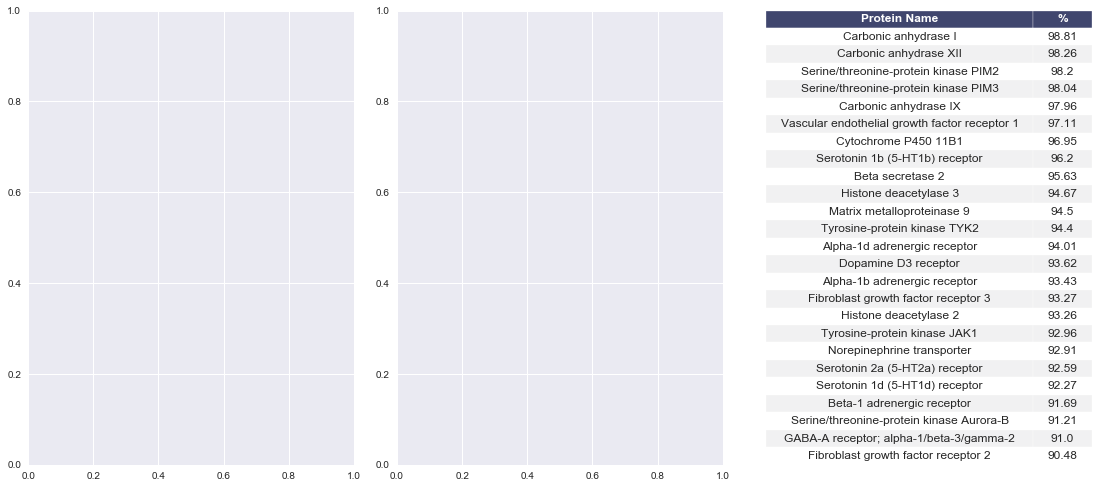

In [431]:
fig, ax = plt.subplots(1,3)

ax[2] = render_mpl_table(names.iloc[:25], np.array([2.3,0.5]), header_columns=0, col_width=2.0, ax=ax[2])

fig.set_figwidth(22)
fig.set_figheight(7)

plt.tight_layout()

In [461]:
plt.rcParams.update(
        {
            "font.size": 25.0,
            "font.family": "normal"
        }
)

In [462]:
# import matplotlib
# font = {'family' : 'serif',
#         'weight' : 'normal',
#         'size'   : 22}

# matplotlib.rc('font', **font)

In [476]:
def plot_fig_label(ax, lab):
    ax.text(-0.1, 1.15, lab, transform=ax.transAxes,
        fontsize=24, fontweight='bold', va='top', ha='right')

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


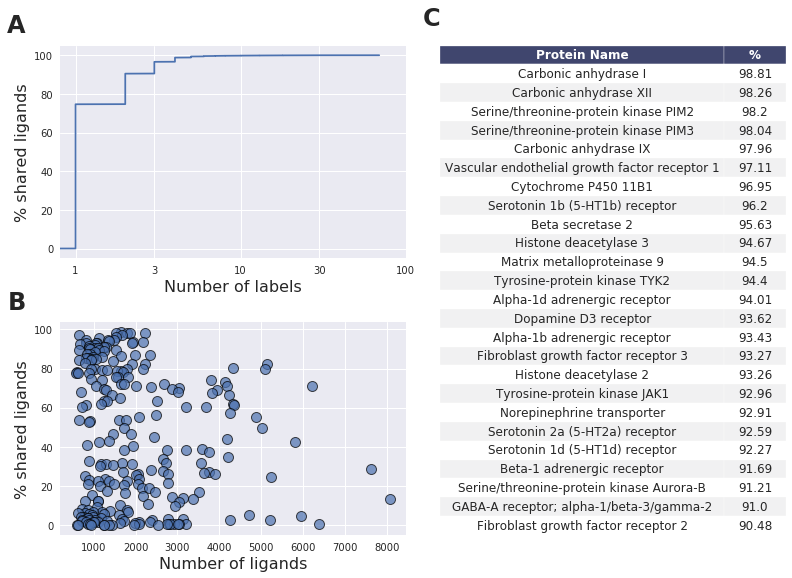

In [488]:
fig = plt.figure(figsize=(13,9))
grid = plt.GridSpec(2, 2, wspace=0.1, hspace=0.3)
ax0=plt.subplot(grid[0, 0])
ax1=plt.subplot(grid[1, 0])
ax2=plt.subplot(grid[:, 1])



ec = ECDF(np.sum(all_interactions, axis=1))
ax0.plot(ec.x, ec.y*100)
ax0.set_xscale('log')
ax0.set_xlabel('Number of labels',fontsize=16)
ax0.set_xticks([1,3,10,30,100])
ax0.set_xticklabels([1,3,10,30,100])
ax0.set_ylabel('% shared ligands', fontsize=16)
plot_fig_label(ax0, 'A')


#ax0.set_xticks([1,2,3,4,5,10,20,30,40,50,100]);
#ax0.set_xticklabels([[1,2,3,4,5,10,20,30,40,50,100]])
ax1.scatter(all_totals, names['%'], alpha=0.7, linewidth=1, s=100, edgecolor='k')
ax1.set_xlabel('Number of ligands', fontsize=16)
ax1.set_ylabel('% shared ligands',fontsize=16)
plot_fig_label(ax1, 'B')

ax2 = render_mpl_table(names.iloc[:25], np.array([2.3,0.5]), header_columns=0, col_width=2.0, ax=ax2)
ax2.text(0, 1.08, 'C', transform=ax2.transAxes,
    fontsize=24, fontweight='bold', va='top', ha='right')

plt.tight_layout()

In [295]:

tot_instances = all_interactions.sum(0)

L = sparse.lil_matrix((interaction_matrix.shape[1], interaction_matrix.shape[1]))

for idx in tqdm.tqdm(range(interaction_matrix.shape[0]), smoothing=0.1):
    row = interaction_matrix[idx]
    if row.sum()>1:
        for j,k in itertools.permutations(row.nonzero()[0], 2):
            L[j,k] += (1)/(tot_instances[k])


100%|██████████| 85681/85681 [00:06<00:00, 13164.09it/s]


In [296]:
corr = L.toarray()

In [297]:
corr.max()

0.9601371624517563

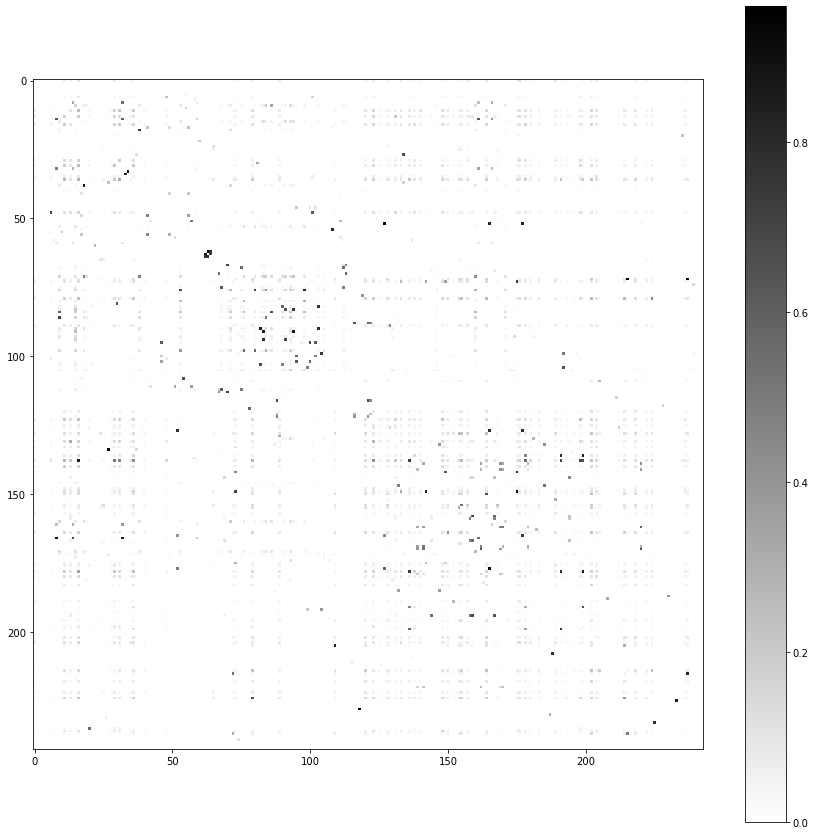

In [356]:
plt.figure(figsize=(15,15))
plt.imshow(corr, cmap='binary')
plt.colorbar()

In [346]:
numpy_names =pd.read_csv('../data/subset_targets', header=None)[0].to_numpy()

ranks = np.dstack(np.unravel_index(np.argsort((-corr).ravel()), (corr.shape[0], corr.shape[0])))[0]

In [347]:
for i in range(numpy_names.shape[0]):
    length=len(numpy_names[i])
    if length>30:
        numpy_names[i]=numpy_names[i][:27]+'...'
        #middle = int(length/2)
        #n = numpy_names[i]
        #n = n[:middle]+'\n'+n[middle:]
        #numpy_names[i]=n

In [348]:
prot1 = list()
prot2 = list()
similarity = list()
for j in ranks[:200:1]:
    prot1.append(numpy_names[j[0]])
    prot2.append(numpy_names[j[1]])
    similarity.append(np.around(100*corr[j[0]][j[1]], 1))

In [349]:
simdf = pd.DataFrame()
simdf['Protein 1'] = prot1
simdf['Protein 2'] = prot2
simdf['%'] = similarity
simdf.iloc[:15]

,Protein 1,Protein 2,%
0,Serine/threonine-protein ki...,Serine/threonine-protein ki...,96.0
1,Beta-secretase 1,Beta secretase 2,95.5
2,Carbonic anhydrase II,Carbonic anhydrase I,94.9
3,Cytochrome P450 11B2,Cytochrome P450 11B1,94.3
4,Serine/threonine-protein ki...,Serine/threonine-protein ki...,93.6
5,Carbonic anhydrase IX,Carbonic anhydrase XII,91.0
6,Histone deacetylase 1,Histone deacetylase 3,90.1
7,Tyrosine-protein kinase JAK2,Tyrosine-protein kinase TYK2,89.6
8,Melatonin receptor 1A,Melatonin receptor 1B,89.3
9,GABA-A receptor; alpha-3/be...,GABA-A receptor; alpha-1/be...,88.6


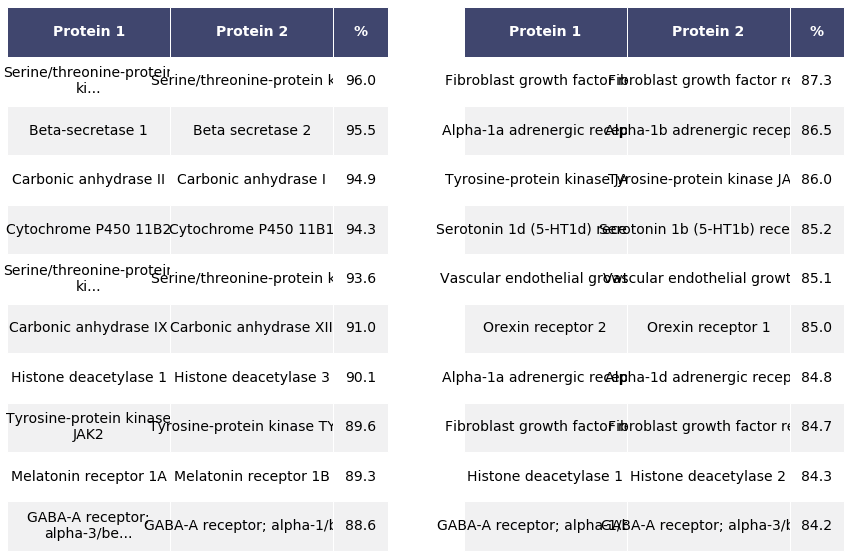

In [355]:
fig, ax = plt.subplots(1,2)

render_mpl_table(simdf.iloc[:10], np.array([1.5,1.5,0.5]),ax=ax[0])
render_mpl_table(simdf.iloc[10:20], np.array([1.5,1.5,0.5]),ax=ax[1])

fig.set_figheight(10)
fig.set_figwidth(15)

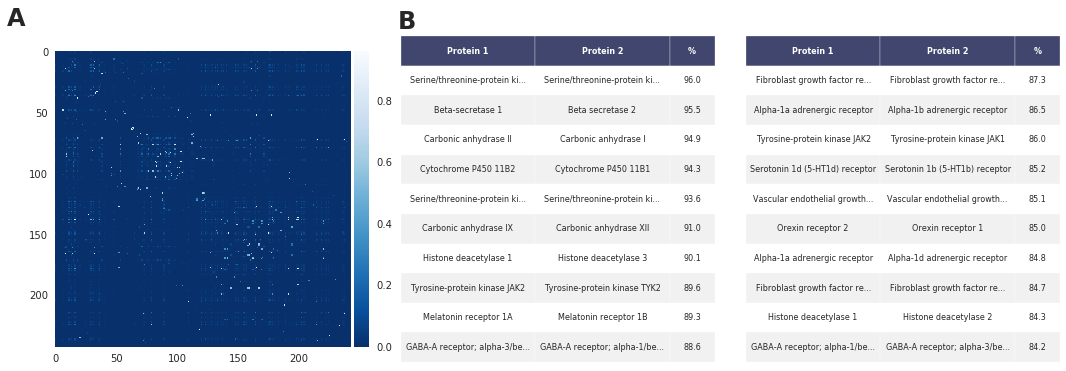

In [556]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1,3, gridspec_kw={'width_ratios': [1.5, 1.5, 1.5]})
fig.set_figwidth(18)
fig.set_figheight(6)
plot_fig_label(ax[0], 'A')


imsh=ax[0].imshow(corr, cmap='Blues_r')
ax[0].grid()


render_mpl_table(simdf.iloc[:10], np.array([1.5,1.5,0.5]),ax=ax[1], font_size=8)
render_mpl_table(simdf.iloc[10:20], np.array([1.5,1.5,0.5]),ax=ax[2], font_size=8)
#plot_fig_label(ax[1], 'B')
ax[1].text(0.05, 1.08, 'B', transform=ax[1].transAxes,
    fontsize=24, fontweight='bold', va='top', ha='right')

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(imsh, cax=cax, orientation='vertical')
fig.subplots_adjust(hspace=0.05, wspace=0.1)
